In [1]:
import os
import torch
import cv2 as cv
import numpy as np
from pyhdf.SD import SD, SDC
from os.path import join as path_join
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
FILE_NAMES = ["br002.hdf"]

In [3]:
def read_hdf(hdf_path, dataset_names):
    print(f"Reading {hdf_path}")
    f = SD(hdf_path, SDC.READ)
    datasets = []
    for dataset_name in dataset_names:
        datasets.append(f.select(dataset_name).get())
    return datasets

In [12]:
def resize_3d(array, new_height, new_width):
    resized_array = np.zeros((array.shape[0], new_height, new_width))

    for i in range(array.shape[0]):
        resized_array[i] = cv.resize(
            array[i], (new_width, new_height), interpolation=cv.INTER_LINEAR
        )

    return resized_array


def get_sim(sim_path, new_height, new_width):
    (b_path,) = [path_join(sim_path, file_name) for file_name in FILE_NAMES]
    b, k = read_hdf(b_path, ["Data-Set-2", "fakeDim2"])

    k = np.expand_dims(np.expand_dims(k, axis=0), axis=0)
    b *= k**2

    b = b.transpose(2, 1, 0)
    
    b = resize_3d(b, new_height, new_width)

    return b


def get_sims(sim_paths, new_height, new_width):
    sims = []
    for sim_path in sim_paths:
        sims.append(get_sim(sim_path, new_height, new_width))
    sims = np.stack(sims, axis=0)
    return sims


def min_max_normalize(array, min_=None, max_=None):
    if min_ is None or max_ is None:
        min_ = np.min(array)
        max_ = np.max(array)
    array = (array - min_) / (max_ - min_)
    return array, min_, max_


class SphericalNODataset(Dataset):
    def __init__(
        self,
        sim_paths,
        input_slice_ix=0,
        target_slice_ix=70,
        height=110,
        width=128,
        b_min=None,
        b_max=None,
    ):
        super().__init__()
        self.input_slice_ix = input_slice_ix
        self.target_slice_ix = target_slice_ix
        sims = get_sims(sim_paths, height, width)
        sims, self.b_min, self.b_max = min_max_normalize(sims, b_min, b_max)
        self.sims = sims

    def __getitem__(self, index):
        cube = self.sims[index]
        input_slice = cube[self.input_slice_ix, :, :]
        target_slice = cube[self.target_slice_ix, :, :]
        return {
            "x": torch.tensor(input_slice, dtype=torch.float32).unsqueeze(0),
            "y": torch.tensor(target_slice, dtype=torch.float32).unsqueeze(0),
        }

    def __len__(self):
        return len(self.sims)

    def get_min_max(self):
        return {"b_min": float(self.b_min), "b_max": float(self.b_max)}

In [13]:
instruments = [
        "kpo_mas_mas_std_0101",
        "mdi_mas_mas_std_0101",
        "hmi_mast_mas_std_0101",
        "hmi_mast_mas_std_0201",
        "hmi_masp_mas_std_0201",
        "mdi_mas_mas_std_0201",
]

In [14]:
subdir_paths = sorted(os.listdir('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train'))
cr_paths = [path_join('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train', p) for p in subdir_paths if p.startswith("cr")]
sim_paths_train = []
for cr_path in cr_paths:
    for instrument in instruments:
        instrument_path = path_join(cr_path, instrument)
        if os.path.exists(instrument_path):
            sim_paths_train.append(instrument_path)
subdir_paths = sorted(os.listdir('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/test'))
cr_paths = [path_join('/Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/test', p) for p in subdir_paths if p.startswith("cr")]
sim_paths_val = []
for cr_path in cr_paths:
    for instrument in instruments:
        instrument_path = path_join(cr_path, instrument)
        if os.path.exists(instrument_path):
            sim_paths_val.append(instrument_path)

In [15]:
train_dataset = SphericalNODataset(sim_paths_train[:10], 0, 70, 32, 64)
val_dataset = SphericalNODataset(sim_paths_val[:1], 0, 70, 32, 64, b_min=train_dataset.b_min, b_max=train_dataset.b_max)

Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1732/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1733/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1734/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1735/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1736/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1737/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1738/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1739/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURROGATE/Data/psi_web_sample/train/cr1740/kpo_mas_mas_std_0101/br002.hdf
Reading /Users/reza/Career/DMLab/SURR

torch.Size([10, 1, 32, 64]) torch.Size([10, 1, 32, 64])


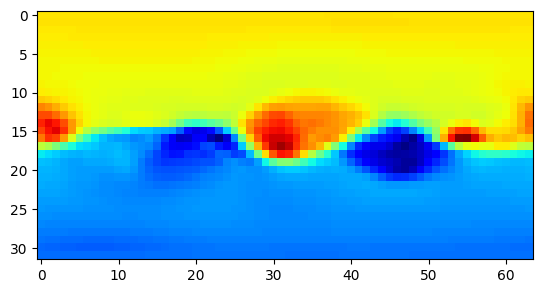

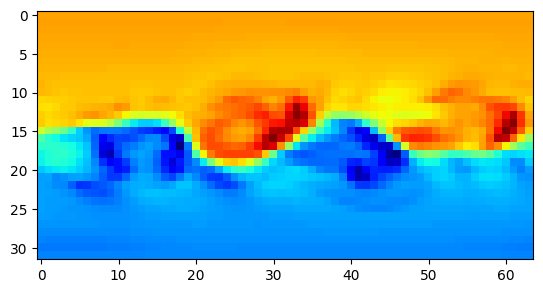

In [16]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Check a batch
sample_batch = next(iter(train_loader))
print(sample_batch['x'].shape, sample_batch['y'].shape)  # Should be (16, 128, 110)
plt.imshow(sample_batch['x'][0].numpy()[0], cmap='jet_r')
plt.show()
plt.imshow(sample_batch['y'][0].numpy()[0], cmap='jet_r')
plt.show()


In [17]:
import sys
from neuralop.models import SFNO
from neuralop import Trainer
from neuralop.training import AdamW
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

/Users/reza/Career/DMLab/SURROGATE/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [36]:
model = SFNO(n_modes=(32, 32),
             in_channels=1,
             out_channels=1,
             hidden_channels=32,
             projection_channel_ratio=2,
             factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 275297 parameters.


In [37]:
optimizer = AdamW(model.parameters(), 
                                lr=8e-4, 
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [38]:
l2loss = LpLoss(d=2, p=2, reduction='sum')

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

In [39]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SphericalConv(
        (weight): ComplexDenseTensor(shape=torch.Size([32, 32, 32]), rank=None)
        (sht_handle): SHT(
          (_SHT_cache): ModuleDict()
          (_iSHT_cache): ModuleDict()
        )
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projectio

In [40]:
trainer = Trainer(model=model, n_epochs=1000,
                  device=device,
                  wandb_log=False,
                  eval_interval=3,
                  use_distributed=False,
                  verbose=True)

In [41]:
trainer.train(train_loader=train_loader,
              test_loaders={(32, 64): val_loader},
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)

Training on 10 samples
Testing on [1] samples         on resolutions [(32, 64)].
Raw outputs of shape torch.Size([10, 1, 32, 64])
[0] time=0.24, avg_loss=1.1009, train_err=11.0089
Eval: (32, 64)_l2=1.0641
[3] time=0.23, avg_loss=0.9867, train_err=9.8672
Eval: (32, 64)_l2=0.9481
[6] time=0.17, avg_loss=0.8730, train_err=8.7304
Eval: (32, 64)_l2=0.8331
[9] time=0.22, avg_loss=0.7622, train_err=7.6221
Eval: (32, 64)_l2=0.7219
[12] time=0.23, avg_loss=0.6581, train_err=6.5813
Eval: (32, 64)_l2=0.6188
[15] time=0.19, avg_loss=0.5661, train_err=5.6609
Eval: (32, 64)_l2=0.5295
[18] time=0.18, avg_loss=0.4918, train_err=4.9176
Eval: (32, 64)_l2=0.4598
[21] time=0.19, avg_loss=0.4391, train_err=4.3908
Eval: (32, 64)_l2=0.4127
[24] time=0.18, avg_loss=0.4083, train_err=4.0829
Eval: (32, 64)_l2=0.3873
[27] time=0.19, avg_loss=0.3953, train_err=3.9533
Eval: (32, 64)_l2=0.3784
[30] time=0.16, avg_loss=0.3929, train_err=3.9290
Eval: (32, 64)_l2=0.3774
[33] time=0.18, avg_loss=0.3920, train_err=3.920

{'train_err': 0.27828145027160645,
 'avg_loss': 0.027828145027160644,
 'avg_lasso_loss': None,
 'epoch_train_time': 0.11665679099996851,
 '(32, 64)_l2': tensor(0.0876)}

/var/folders/bv/7h0f0hns2y72yqgg3ww8qkkm0000gn/T/ipykernel_4573/1565346799.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


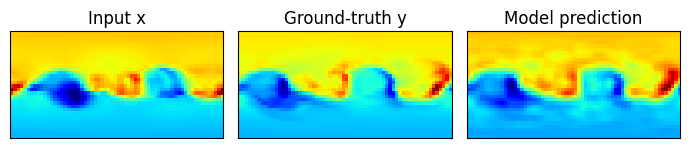

In [35]:
fig = plt.figure(figsize=(7, 7))
test_samples = train_loader.dataset
data = test_samples[np.random.randint(0, len(test_samples))]
# Input x
x = data['x']
# Ground-truth
y = data['y'][0, ...].numpy()
# Model prediction
x_in = x.unsqueeze(0).to(device)
out = model(x_in).squeeze().detach().cpu().numpy()
x = x[0, ...].detach().numpy()

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x, cmap='jet_r')
ax.set_title(f'Input x')
plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(y, cmap='jet_r')
ax.set_title('Ground-truth y')
plt.xticks([], [])
plt.yticks([], [])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(out, cmap='jet_r')
ax.set_title('Model prediction')
plt.xticks([], [])
plt.yticks([], [])

# fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()